In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#List des import

In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.applications import MobileNetV2
from keras.layers import Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, Concatenate,GlobalAveragePooling2D
import pandas

In [41]:
cd /content/drive/MyDrive/ProjetDeep/

/content/drive/MyDrive/ProjetDeep


#DATA augmentation

In [42]:
#charger la Datase

BASE_PATH = "BarkNet"
TRAIN = "BarkNet_train"
TEST = "BarkNet_test"

#labelNames = ["BOJ", "BOP", "CHR", "EPB", "EPN", "EPO", "ERR", "ERS", "FRA","HEG","MEL","ORA","OSV","PET","PIB","PIR","PRU","SAB","THO"]

# chemins vers les repertoires train, val et test
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
testPath = os.path.sep.join([BASE_PATH, TEST])

# nbr total des image dans chacun des repo train test
totalTrain = len(list(paths.list_images(trainPath)))
print(totalTrain)
# totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTest)


1912
448


#DATA augmentation

In [43]:
# instancier un objet ImageDataGenerator pour l'augmentation des donnees train
trainAug = ImageDataGenerator(
    horizontal_flip=True )

# instancier un objet ImageDataGenerator pour l'augmentation des donnees test
testAug = ImageDataGenerator()

# definir la moyenne des images ImageNet par plan RGB pour normaliser les images de la BarkNet
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
testAug.mean = mean
# initialiser le generateur de train

trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    batch_size=32)

# initialiser le generateur de test
testGen  = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224,224),
    color_mode="rgb",
    shuffle=False,  
    batch_size=32)


Found 1912 images belonging to 20 classes.
Found 448 images belonging to 20 classes.


#model.summary() sans la dernière couche FC.

In [44]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
#model.summary() sans la dernière couche FC.
baseModel.summary()                                                                                                                                                                                         

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

##model.summary() avec la dernière couche FC.

In [45]:
# charger le model VGG16 pre-entrainer sur imagenet et sans la derniere FC: ceci forme la partie basale du modele
baseModel = MobileNetV2(weights="imagenet", include_top=True,
                  input_tensor=Input(shape=(224, 224, 3)))
#model.summary() avec la dernière couche FC.
baseModel.summary()  

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

#5-Définir une nouvelle couche FC identique à l’ancienne et reconstruire le modéle

In [48]:


#charger le modéle MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
              input_tensor=Input(shape=(224, 224, 3)))
  

#FC layer: 
gaveragepool = GlobalAveragePooling2D()(baseModel.output)
output = Dense(20, activation='softmax')(gaveragepool)
#inputs and outputs of our model
model = Model(inputs=baseModel.input, outputs=output)
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss= 'categorical_crossentropy' , optimizer= opt , metrics=['accuracy'])


#7-Faire un fine-tuning sur la nouvelle FC pour un certain nombre d’epoch

In [49]:
# geler (ou bien freeze) toute les couche basale du modèle, càd on ne va pas changer leur poids mais laisser les poids
# appris sur imagenet
#model = build()
i=0
for layer in baseModel.layers:
    layer.trainable = False
    i+=1
    print(i)


# visualiser les couches à entrainer
for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))
    


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0b7263a2e8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f0b7263a438>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b7263a4a8>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0b7263a940>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f0b7263ae48>: False
<tensorflow.python.keras.laye

#entrainer le modéle 

In [50]:
H = model.fit_generator(
      trainGen,
      steps_per_epoch=totalTrain // 32 ,
      validation_data=testGen,
      validation_steps=totalTest // 32,
      epochs=50)

Epoch 1/50
59/59 [==============================] - 14s 242ms/step - loss: 2.8988 - accuracy: 0.1346 - val_loss: 3.4572 - val_accuracy: 0.0558
Epoch 2/50
59/59 [==============================] - 14s 233ms/step - loss: 2.3692 - accuracy: 0.3298 - val_loss: 3.1989 - val_accuracy: 0.0826
Epoch 3/50
59/59 [==============================] - 14s 233ms/step - loss: 2.0078 - accuracy: 0.4436 - val_loss: 3.0987 - val_accuracy: 0.1295
Epoch 4/50
59/59 [==============================] - 14s 229ms/step - loss: 1.7544 - accuracy: 0.5122 - val_loss: 3.0933 - val_accuracy: 0.1205
Epoch 5/50
59/59 [==============================] - 13s 229ms/step - loss: 1.5603 - accuracy: 0.5612 - val_loss: 3.1730 - val_accuracy: 0.1228
Epoch 6/50
59/59 [==============================] - 13s 228ms/step - loss: 1.3838 - accuracy: 0.6218 - val_loss: 3.3453 - val_accuracy: 0.1317
Epoch 7/50
59/59 [==============================] - 13s 229ms/step - loss: 1.2458 - accuracy: 0.6654 - val_loss: 3.5014 - val_accuracy: 0.1250

#plot

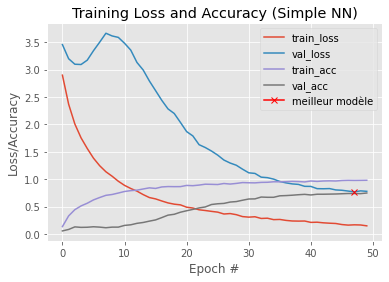

In [51]:
# afficher le graphe de loss et accuracy
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,50)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#Freeze pour les 50 premiére couches

In [58]:
model.trainable = True

#model = build()
fine_tune_at = 50
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False
# visualiser les couches à entrainer
for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))

opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss= 'categorical_crossentropy' , optimizer= opt , metrics=['accuracy'])



<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f0b7263a2e8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f0b7263a438>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b7263a4a8>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0b7263a940>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f0b7263ae48>: False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f0b7262e198>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0b72647780>: False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f0b72647f98>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f0b7264c198>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0b725e63c8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

# Entrainer le modéle

In [59]:

#entrainer le model
H = model.fit_generator(
      trainGen,
      steps_per_epoch=totalTrain // 32 ,
      validation_data=testGen,
      validation_steps=totalTest // 32,
      epochs=100)

Epoch 1/100
59/59 [==============================] - 8s 130ms/step - loss: 0.0964 - accuracy: 0.9691 - val_loss: 10.7209 - val_accuracy: 0.2701
Epoch 2/100
59/59 [==============================] - 7s 119ms/step - loss: 0.0777 - accuracy: 0.9761 - val_loss: 9.2397 - val_accuracy: 0.3214
Epoch 3/100
59/59 [==============================] - 7s 122ms/step - loss: 0.0608 - accuracy: 0.9793 - val_loss: 7.9622 - val_accuracy: 0.3705
Epoch 4/100
59/59 [==============================] - 7s 121ms/step - loss: 0.0868 - accuracy: 0.9777 - val_loss: 6.9311 - val_accuracy: 0.3929
Epoch 5/100
59/59 [==============================] - 7s 121ms/step - loss: 0.0515 - accuracy: 0.9819 - val_loss: 6.0493 - val_accuracy: 0.4487
Epoch 6/100
59/59 [==============================] - 7s 121ms/step - loss: 0.0548 - accuracy: 0.9840 - val_loss: 5.3163 - val_accuracy: 0.4933
Epoch 7/100
59/59 [==============================] - 7s 120ms/step - loss: 0.0517 - accuracy: 0.9824 - val_loss: 4.7088 - val_accuracy: 0.508

#Plot

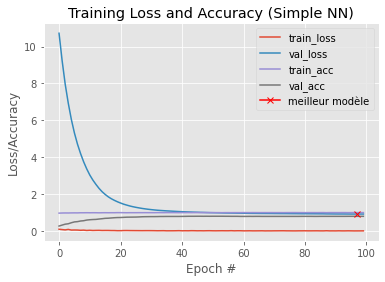

In [60]:
# afficher le graphe de loss et accuracy
N = np.arange(0, 100)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,100)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#charger la Dataset pour extraire X_train, y_train, Y_test, Y_train

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
IMG_SIZE = 224
DATADIR = "/content/drive/MyDrive/ProjetDeep/BarkNet/BarkNet_train"

CATEGORIES = ["BOJ", "BOP", "CHR", "EPB", "EPN", "EPO","EPR", "ERR", "ERS", "FRA","HEG","MEL","ORA","OSV","PET","PIB","PIR","PRU","SAB","THO"]
training_data = []
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
DATATESTDIR = "/content/drive/MyDrive/ProjetDeep/BarkNet/BarkNet_test"
test_data = []
def create_testing_data():
    for category in CATEGORIES:  

        path = os.path.join(DATATESTDIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                test_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

In [78]:
create_training_data()

100%|██████████| 58/58 [00:00<00:00, 367.37it/s]


In [79]:
print(len(training_data))

1912


In [80]:
create_testing_data()

100%|██████████| 17/17 [00:00<00:00, 320.16it/s]


In [ ]:
print(len(test_data))

In [81]:
import random

random.shuffle(training_data)

In [ ]:
print(len(training_data))

#Extraire les X_train , y_train

In [82]:
X_train = []
y_train = []

for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

#Extraire X_test , y_test

In [83]:
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)



X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(len(y_test))

448


#Grille de recherche 

In [ ]:
#évaluation du batch et epoch

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
# creer le modele
model1 = KerasClassifier(build_fn=build,verbose=1)
# parametres de la grille de recherche

epochs = [20, 40, 60]
batch_size = [8, 16, 32]
param_grid = dict(epochs=epochs,batch_size=batch_size)
#la grille de recherche avec une validation croisée de 3 fold
grid = GridSearchCV(estimator=model1, param_grid=param_grid, cv=3)
# lancer l’entrainement de la grille de recherche sur le train

#print(X.shape)
#print(Y.shape)

grid_result = grid.fit(X_train,y_train)

# afficher les résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Visualiser l'architecture du modéle

In [ ]:
model = build()
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#build and train bestmodel


In [62]:
epochs = 60
batch_size  =8

#recompiler le modéle
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss= 'categorical_crossentropy' , optimizer= opt , metrics=['accuracy'])
#fit
H=model.fit(trainGen, validation_data=testGen, epochs=epochs, batch_size=batch_size)


Epoch 1/60
60/60 [==============================] - 14s 239ms/step - loss: 2.9017 - accuracy: 0.1412 - val_loss: 3.7426 - val_accuracy: 0.0580
Epoch 2/60
60/60 [==============================] - 14s 231ms/step - loss: 2.3614 - accuracy: 0.3211 - val_loss: 3.6244 - val_accuracy: 0.0737
Epoch 3/60
60/60 [==============================] - 14s 234ms/step - loss: 1.9680 - accuracy: 0.4686 - val_loss: 3.5273 - val_accuracy: 0.0737
Epoch 4/60
60/60 [==============================] - 13s 224ms/step - loss: 1.7100 - accuracy: 0.5246 - val_loss: 3.4015 - val_accuracy: 0.1116
Epoch 5/60
60/60 [==============================] - 14s 228ms/step - loss: 1.5063 - accuracy: 0.5826 - val_loss: 3.2733 - val_accuracy: 0.1429
Epoch 6/60
60/60 [==============================] - 14s 232ms/step - loss: 1.3357 - accuracy: 0.6428 - val_loss: 3.1991 - val_accuracy: 0.1339
Epoch 7/60
60/60 [==============================] - 14s 232ms/step - loss: 1.2171 - accuracy: 0.6799 - val_loss: 3.1009 - val_accuracy: 0.1406

#Plot

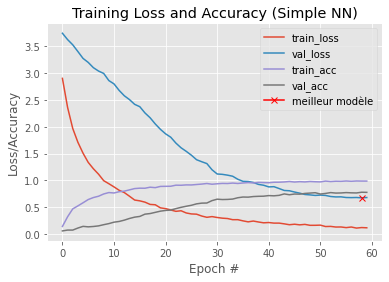

In [63]:
# afficher le graphe de loss et accuracy
N = np.arange(0, 60)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,60)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#Dégradation du taux d'apprentissage

In [70]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
import math



model= build()

def lr_decay(epoch, current_learning_rate):
    if epoch ==5:
       return current_learning_rate * 0.2
    else:
       return current_learning_rate

# learning schedule callback
lrate = LearningRateScheduler(lr_decay,verbose=1)
callbacks_list = [lrate]

#recompiler le modéle
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss= 'categorical_crossentropy' , optimizer= opt , metrics=['accuracy'])

H=model.fit(trainGen,validation_data= testGen ,callbacks=callbacks_list, verbose=1,batch_size=8,epochs=60)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/60
60/60 [==============================] - 15s 242ms/step - loss: 2.9929 - accuracy: 0.1177 - val_loss: 3.5585 - val_accuracy: 0.0513

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/60
60/60 [==============================] - 14s 233ms/step - loss: 2.3758 - accuracy: 0.3384 - val_loss: 3.4732 - val_accuracy: 0.0692

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/60
60/60 [==============================] - 14s 230ms/step - loss: 2.0066 - accuracy: 0.4430 - val_loss: 3.3334 - val_accuracy: 0.0982

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/60
60/60 [==============================] - 13s 221ms/step - loss: 1.7209 - accuracy: 0.5246 - val_loss: 3.1775 - val_accuracy: 0.0982

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epo

#PLOT

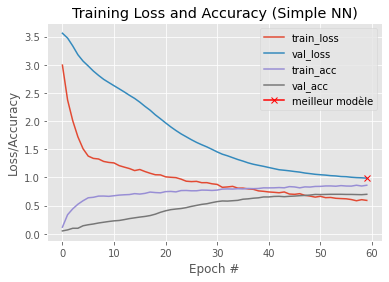

In [72]:
# afficher le graphe de loss et accuracy
N = np.arange(0, 60)
plt.style.use("ggplot")
plt.figure()
N = np.arange(0,60)
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.plot(np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]),marker="x",color="r", label="meilleur modèle")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("barknettpart2transfert")


#sauvegarder l'historique de l'entrainement

In [84]:
with open('part2_file.json', 'w') as f:
    json.dump(str(H.history), f)

#Save model

In [85]:
model.save("partie2.h5")
print("modèle sauvegardé")

modèle sauvegardé


#load Model

In [86]:
from keras.models import load_model

model = load_model('partie2.h5')
model.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________

#Visualiser les mesures performances

In [87]:
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# evaluer le modele sur l'ensemble test
predictions = model.predict(testGen, batch_size=batch_size)


y_pred= np.argmax(predictions,axis=1)
# imprimer le rappel/ precision ainsi que la mesure F
CATEGORIES = ["BOJ", "BOP", "CHR", "EPB", "EPN", "EPO","EPR", "ERR", "ERS", "FRA","HEG","MEL","ORA","OSV","PET","PIB","PIR","PRU","SAB","THO"]
report =classification_report(y_test, y_pred,target_names=CATEGORIES,output_dict=True)



# sauvegarder les mesures de performances 

In [88]:
df = pandas.DataFrame(report).transpose()
print(df)
df.to_csv('performance_part2.csv',index=True)


              precision    recall  f1-score     support
BOJ            0.869565  0.740741  0.800000   27.000000
BOP            0.868421  1.000000  0.929577   33.000000
CHR            0.750000  0.568966  0.647059   58.000000
EPB            0.750000  0.461538  0.571429   13.000000
EPN            0.625000  0.666667  0.645161   15.000000
EPO            0.708333  0.653846  0.680000   26.000000
EPR            0.500000  0.210526  0.296296   19.000000
ERR            0.500000  0.464286  0.481481   28.000000
ERS            0.512195  0.777778  0.617647   27.000000
FRA            0.558824  1.000000  0.716981   19.000000
HEG            0.937500  0.882353  0.909091   17.000000
MEL            0.700000  0.945946  0.804598   37.000000
ORA            0.714286  0.526316  0.606061   19.000000
OSV            0.833333  0.500000  0.625000   10.000000
PET            0.842105  0.800000  0.820513   20.000000
PIB            0.500000  0.500000  0.500000   22.000000
PIR            0.750000  0.750000  0.750000    8

#sauvegarder le graphe 

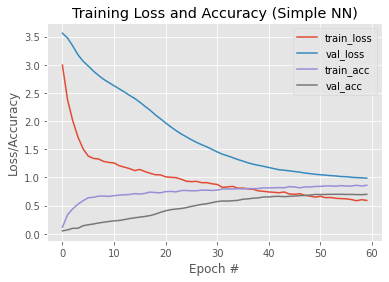

In [89]:
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#sauvegarde du graphe
plt.savefig("BarkNet_partie2.PNG")